In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

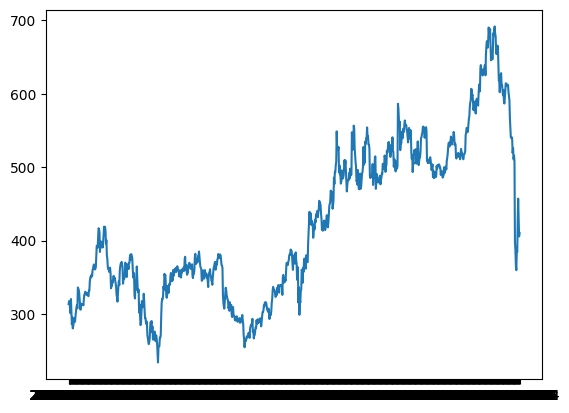

In [2]:
nflx = pd.read_csv("NFLX_2.csv")
nflx
close_prices = nflx['Close']
dates = nflx['Date']
plt.plot(dates, close_prices)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

nflx = nflx[['Date','Close','Day','Month']]
nflx

,Date,Close,Day,Month
0,2018-03-19,313.480011,19,3
1,2018-03-20,317.500000,20,3
2,2018-03-21,316.480011,21,3
3,2018-03-22,306.700012,22,3
4,2018-03-23,300.940002,23,3
...,...,...,...,...
975,2022-01-31,427.140015,31,1
976,2022-02-01,457.130005,1,2
977,2022-02-02,429.480011,2,2
978,2022-02-03,405.600006,3,2


In [4]:
device ='cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_fro_lstm(df,n_steps):
    df = dc(df)
    df.set_index('Date',inplace = True)
    for i in range(1,n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace = True)
    return df

lookback = 7
nflx = prepare_dataframe_fro_lstm(nflx,lookback)
nflx

,Close,Day,Month,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,,,
2018-03-28,285.769989,28,3,300.690002,320.350006,300.940002,306.700012,316.480011,317.500000,313.480011
2018-03-29,295.350006,29,3,285.769989,300.690002,320.350006,300.940002,306.700012,316.480011,317.500000
2018-04-02,280.290009,2,4,295.350006,285.769989,300.690002,320.350006,300.940002,306.700012,316.480011
2018-04-03,283.670013,3,4,280.290009,295.350006,285.769989,300.690002,320.350006,300.940002,306.700012
2018-04-04,288.940002,4,4,283.670013,280.290009,295.350006,285.769989,300.690002,320.350006,300.940002
...,...,...,...,...,...,...,...,...,...,...
2022-01-31,427.140015,31,1,384.359985,386.700012,359.700012,366.420013,387.149994,397.500000,508.250000
2022-02-01,457.130005,1,2,427.140015,384.359985,386.700012,359.700012,366.420013,387.149994,397.500000
2022-02-02,429.480011,2,2,457.130005,427.140015,384.359985,386.700012,359.700012,366.420013,387.149994


In [6]:
nflx_mtx = nflx.to_numpy()
nflx_mtx

array([[285.769989,  28.      ,   3.      , ..., 316.480011, 317.5     ,
        313.480011],
       [295.350006,  29.      ,   3.      , ..., 306.700012, 316.480011,
        317.5     ],
       [280.290009,   2.      ,   4.      , ..., 300.940002, 306.700012,
        316.480011],
       ...,
       [429.480011,   2.      ,   2.      , ..., 359.700012, 366.420013,
        387.149994],
       [405.600006,   3.      ,   2.      , ..., 386.700012, 359.700012,
        366.420013],
       [410.170013,   4.      ,   2.      , ..., 384.359985, 386.700012,
        359.700012]])

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler(feature_range=(-1,1))
nflx_mtx = scaler.fit_transform(nflx_mtx)

nflx_mtx

array([[-0.77331214,  0.8       , -0.63636364, ..., -0.63915158,
        -0.63469564, -0.65225746],
       [-0.73146064,  0.86666667, -0.63636364, ..., -0.68187673,
        -0.63915158, -0.63469564],
       [-0.79725212, -0.93333333, -0.45454545, ..., -0.70704005,
        -0.68187673, -0.63915158],
       ...,
       [-0.14549701, -0.93333333, -0.81818182, ..., -0.45033963,
        -0.42098246, -0.33042096],
       [-0.24981978, -0.86666667, -0.81818182, ..., -0.33238676,
        -0.45033963, -0.42098246],
       [-0.22985514, -0.8       , -0.81818182, ..., -0.34260946,
        -0.33238676, -0.45033963]])

In [8]:
X = nflx_mtx[:,1:]
y = nflx_mtx[:,0]

X.shape, y.shape

((973, 9), (973,))

In [9]:
X = dc(np.flip(X,axis=1))
X

array([[-0.65225746, -0.63469564, -0.63915158, ..., -0.70813221,
        -0.63636364,  0.8       ],
       [-0.63469564, -0.63915158, -0.68187673, ..., -0.77331214,
        -0.63636364,  0.86666667],
       [-0.63915158, -0.68187673, -0.70704005, ..., -0.73146064,
        -0.45454545, -0.93333333],
       ...,
       [-0.33042096, -0.42098246, -0.45033963, ..., -0.02470457,
        -0.81818182, -0.93333333],
       [-0.42098246, -0.45033963, -0.33238676, ..., -0.14549701,
        -0.81818182, -0.86666667],
       [-0.45033963, -0.33238676, -0.34260946, ..., -0.24981978,
        -0.81818182, -0.8       ]])

In [10]:
split_index = int(len(X)*0.95)

split_index

924

In [11]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((924, 9), (49, 9), (924,), (49,))

In [12]:
num_columns = X_train.shape[1]

X_train = X_train.reshape((-1,num_columns,1))
X_test = X_test.reshape(-1,num_columns,1)

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((924, 9, 1), (49, 9, 1), (924, 1), (49, 1))

In [13]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

(torch.Size([924, 9, 1]),
 torch.Size([49, 9, 1]),
 torch.Size([924, 1]),
 torch.Size([49, 1]))

In [14]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [15]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [18]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [19]:
learning_rate = 0.001
num_epochs = 25
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.309
***************************************************

Epoch: 2

Val Loss: 0.238
***************************************************

Epoch: 3

Val Loss: 0.181
***************************************************

Epoch: 4

Val Loss: 0.122
***************************************************

Epoch: 5

Val Loss: 0.049
***************************************************

Epoch: 6

Val Loss: 0.031
***************************************************

Epoch: 7

Val Loss: 0.029
***************************************************

Epoch: 8

Val Loss: 0.027
***************************************************

Epoch: 9

Val Loss: 0.025
***************************************************

Epoch: 10

Val Loss: 0.025
***************************************************

Epoch: 11

Val Loss: 0.023
***************************************************

Epoch: 12

Val Loss: 0.022
***************************************************

Epoch: 13

Val Loss: 0.021
**********************

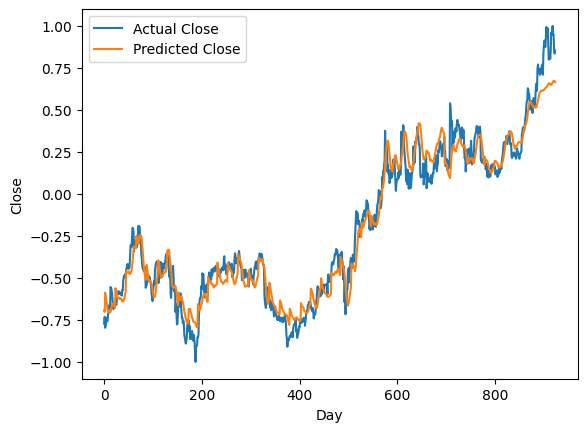

In [20]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [21]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], num_columns+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([303.8078012 , 301.94341671, 328.19231637, 323.62198409,
       319.46288962, 315.76580154, 311.23529552, 305.06584152,
       303.77816686, 302.19349394, 302.22962272, 302.64057401,
       301.22816772, 301.88558063, 304.24996951, 307.53895785,
       310.57014657, 312.27822767, 313.55182193, 313.41059495,
       312.77694954, 309.98830667, 307.63932165, 334.31678675,
       330.74934207, 328.2120726 , 326.71323282, 321.91473526,
       320.98376413, 320.79110002, 321.02836572, 321.46312544,
       319.57831618, 320.31952932, 320.12948481, 319.47025727,
       318.66576418, 316.5950172 , 316.23623981, 316.45977984,
       317.6391773 , 319.94743557, 322.90947751, 326.16406983,
       329.81766147, 358.09295212, 355.50082092, 355.75878427,
       356.11526951, 356.72195477, 357.16395935, 354.34706017,
       354.42785876, 353.71977277, 354.57024547, 357.08050022,
       359.017306  , 363.37072914, 369.68235153, 377.91447538,
       386.12929889, 391.03653755, 390.47718263, 391.20

In [22]:
dummies = np.zeros((X_train.shape[0], num_columns+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([285.76998664, 295.35000888, 280.29000849, 283.67001463,
       288.94000103, 293.97000662, 288.85000652, 289.92999524,
       298.07000979, 303.67001245, 309.24999966, 311.64999885,
       307.78000288, 336.06000065, 334.51998388, 332.70000996,
       327.76998615, 318.68999557, 307.01998858, 305.76001084,
       313.98000534, 311.76000882, 312.45999039, 313.29998465,
       313.35999009, 311.69000248, 320.08999965, 326.26001304,
       326.89001556, 330.29998348, 329.60000191, 326.45999023,
       328.53000045, 326.13000126, 328.18999693, 325.22000065,
       324.17998827, 331.82001208, 331.61999395, 344.72000774,
       349.29000575, 351.29000962, 349.73001151, 353.54000887,
       351.60000361, 359.92999444, 361.81000108, 365.79998746,
       367.45001419, 361.39999121, 360.57000468, 361.45000939,
       363.8299863 , 379.92999226, 392.86999836, 391.98001322,
       390.39999283, 404.98001112, 416.76001102, 415.44000055,
       411.08999519, 384.48000892, 399.39001618, 390.39

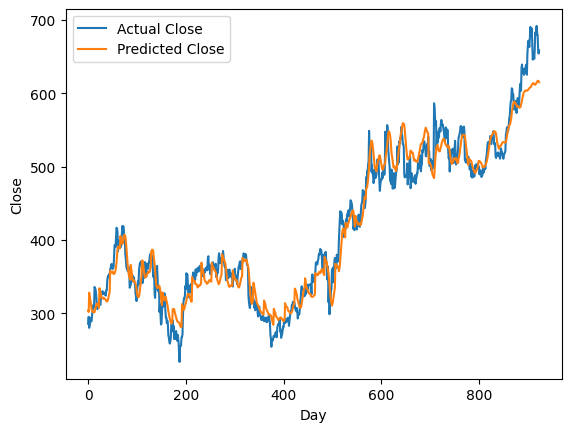

In [23]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], num_columns+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([613.21274079, 610.76421059, 609.34625127, 606.4170909 ,
       604.70769999, 603.40253397, 602.89374298, 601.36750646,
       600.41084405, 599.82096796, 599.14246173, 600.08717216,
       599.7536358 , 599.47613453, 599.07526601, 597.36094968,
       595.15287784, 594.00015402, 593.54786201, 594.00438359,
       593.27113843, 593.36499414, 593.80893614, 594.24257707,
       594.30393325, 557.37428404, 556.9445043 , 556.00300016,
       553.01671319, 548.69652636, 544.32389275, 538.2418546 ,
       532.89615874, 527.55330762, 520.56736081, 516.2932491 ,
       511.09483808, 507.619223  , 503.28698187, 481.54317665,
       457.76638878, 432.52405543, 406.40617377, 386.93795333,
       368.97245092, 387.80580824, 392.62167436, 398.23517075,
       403.78982142])

In [25]:
dummies = np.zeros((X_test.shape[0], num_columns+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([665.64001531, 663.84002956, 641.90001966, 617.77001595,
       616.46996636, 602.13000393, 612.69000583, 625.58001423,
       628.08002249, 611.00000276, 611.65996707, 604.5599922 ,
       597.98998349, 605.03998112, 591.05999674, 586.72998637,
       593.73999402, 604.91998389, 614.23999622, 614.09002355,
       613.11999023, 610.71001741, 610.53997472, 612.09003332,
       602.44000473, 597.36999552, 591.15001854, 567.52001921,
       553.28997806, 541.05999536, 539.84997439, 540.84003   ,
       537.219968  , 519.20001318, 525.69000099, 510.79998871,
       515.85998337, 508.2499998 , 397.50000181, 387.14999165,
       366.42001636, 359.70001452, 386.70001226, 384.3599844 ,
       427.14001367, 457.13000481, 429.48001084, 405.60000591,
       410.17001415])

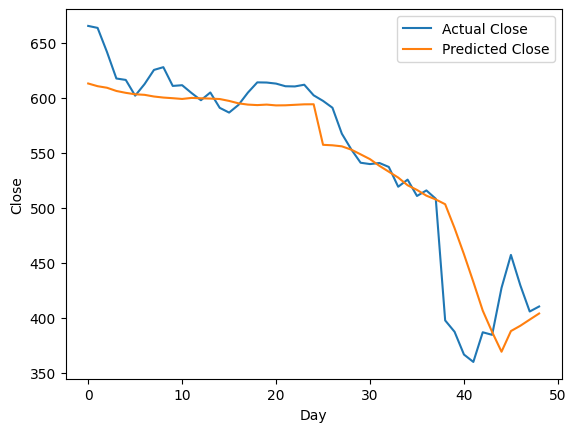

In [26]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
dummies = np.zeros((100, num_columns+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (49,) into shape (100,)